In [1]:
!apt-get -qq install git

In [2]:
!git clone https://github.com/akshi0409/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 584, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 584 (delta 9), reused 140 (delta 8), pack-reused 443
Receiving objects: 100% (584/584), 165.79 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Updating files: 100% (268/268), done.


In [3]:
%cd dataset

/content/dataset


In [4]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from scipy.io import wavfile
recordings_dir = "wooddataset/"
OUTPUT_DIR = '/content/dataset/Working'

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

In [7]:
parent_list = os.listdir(recordings_dir)
for i in range(10):
    print(parent_list[i])

1_bird_85.wav
1_bird_37.wav
0_tree_56.wav
1_bird_25.wav
1_bird_13.wav
0_tree_110.wav
1_bird_82.wav
0_tree_8.wav
0_tree_48.wav
0_tree_71.wav


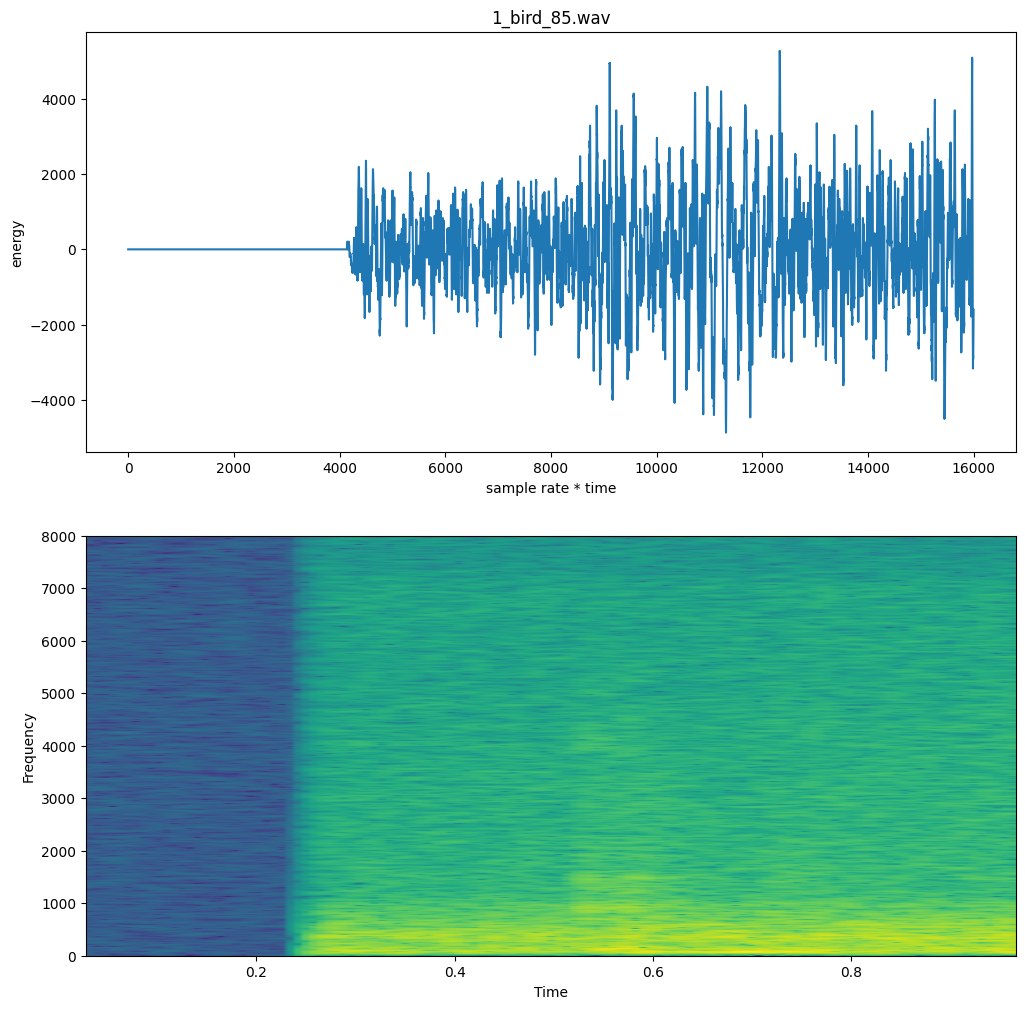

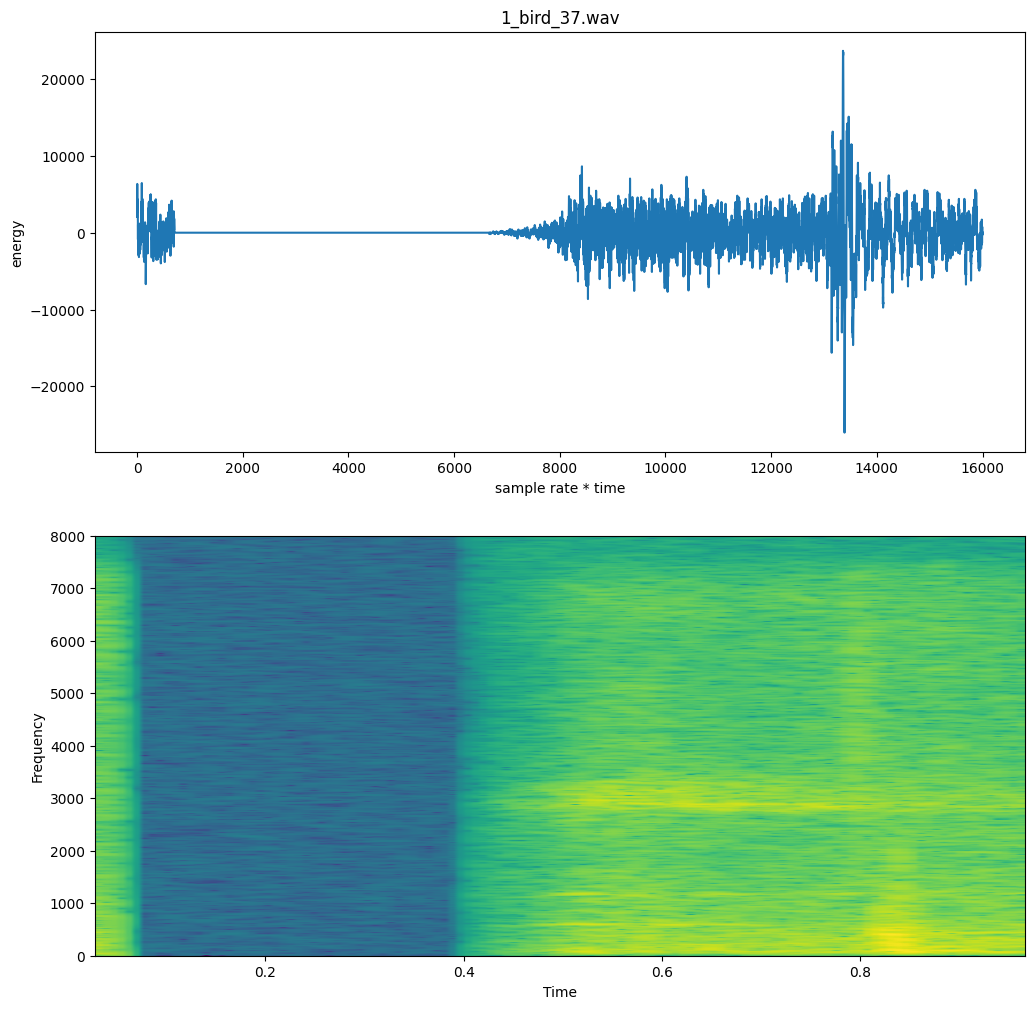

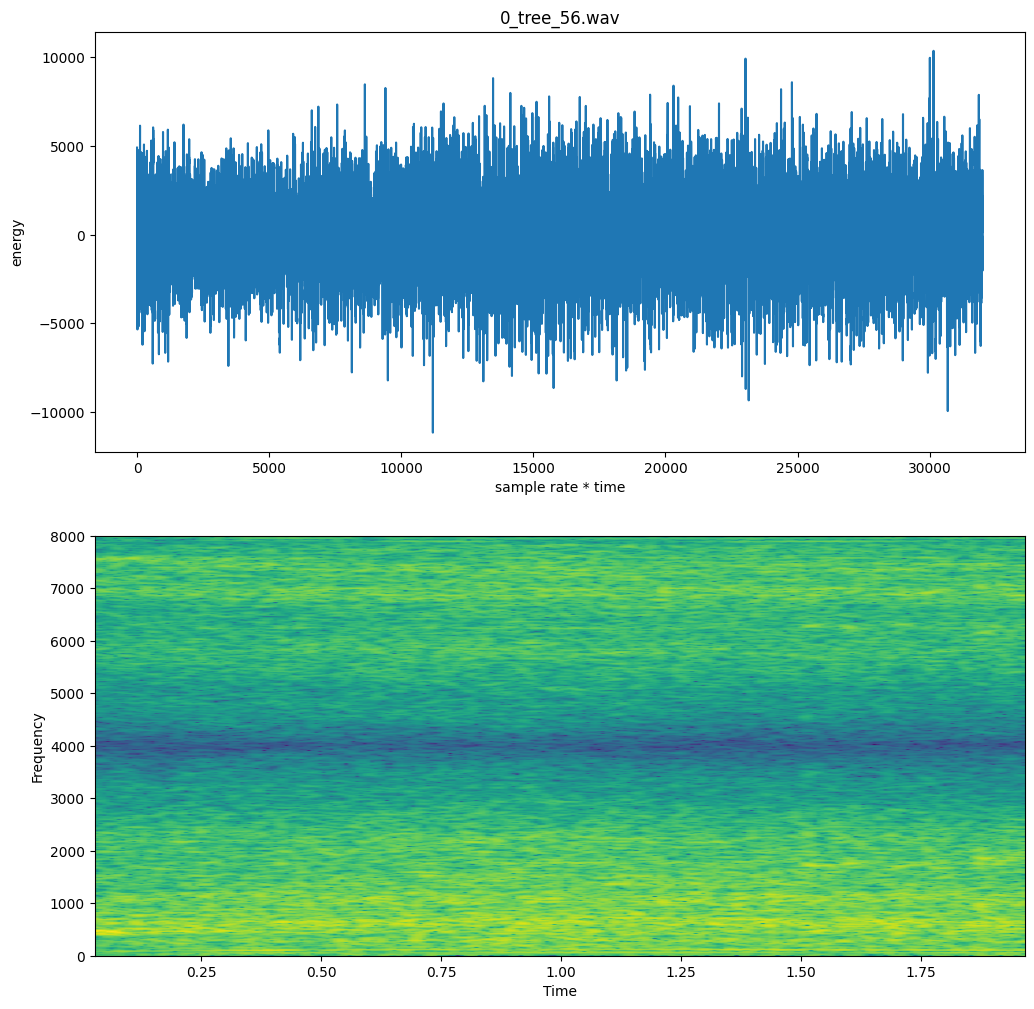

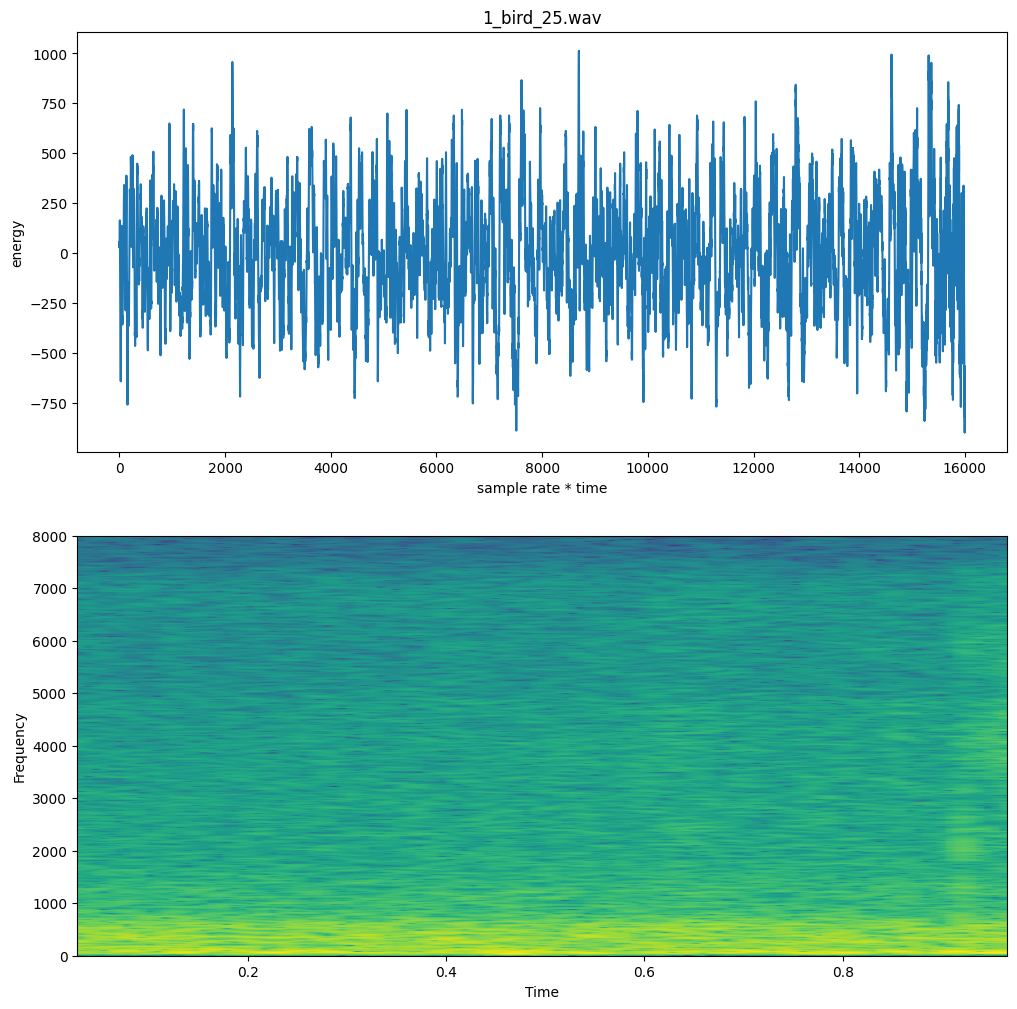

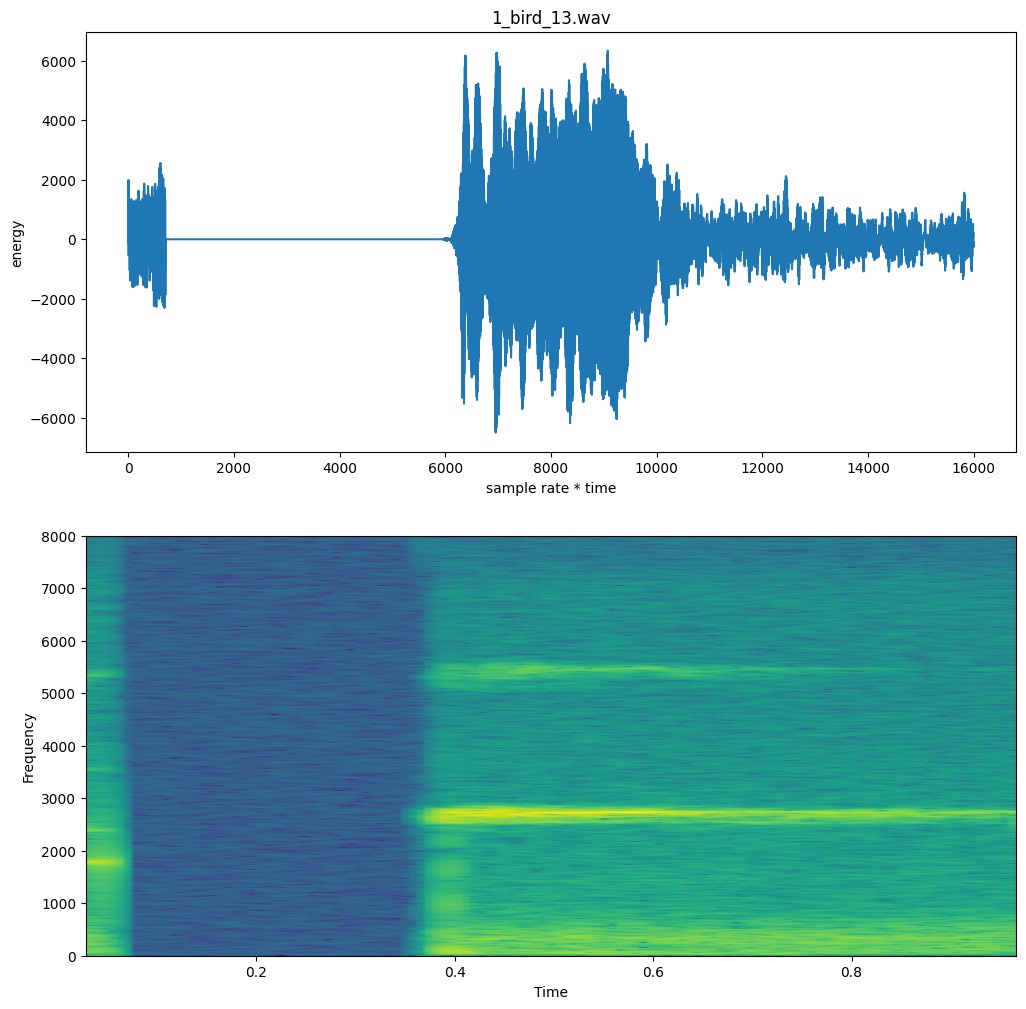

In [8]:
for i in range(5): 
    signal_wave = wave.open(os.path.join(recordings_dir, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')
    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [8]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

In [9]:
y= []
for filename in os.listdir(recordings_dir):
    if "wav" in filename:
        file_path = os.path.join(recordings_dir, filename)
        file_stem = Path(file_path).stem
        y.append(file_stem[0])
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [10]:
# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(2):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_0
class_1

A few example files: 

1_bird_21.png
1_bird_41.png
1_bird_54.png
1_bird_17.png
1_bird_47.png
1_bird_59.png
1_bird_141.png
1_bird_117.png
1_bird_9.png
1_bird_89.png


In [11]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 2

In [12]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                                    validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

Found 261 files belonging to 2 classes.
Using 209 files for training.


In [13]:
# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 261 files belonging to 2 classes.
Using 52 files for validation.


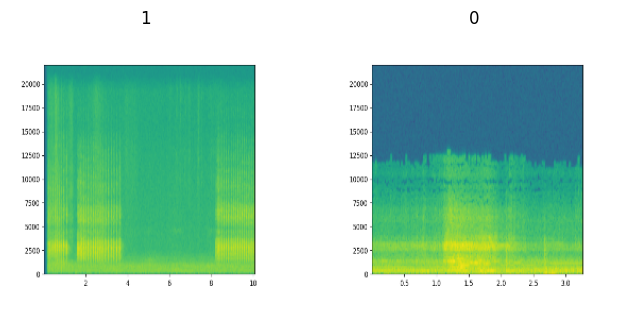

In [14]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [15]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
     # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [16]:
import keras

In [17]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

In [18]:
# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
7/7 [==============================] - 16s 229ms/step - loss: 0.2609 - accuracy: 0.8995 - val_loss: 1.4862 - val_accuracy: 0.3654
Epoch 2/10
7/7 [==============================] - 2s 89ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.4095 - val_accuracy: 0.3654
Epoch 3/10
7/7 [==============================] - 2s 138ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 2.1262 - val_accuracy: 0.3654
Epoch 4/10
7/7 [==============================] - 2s 95ms/step - loss: 0.0168 - accuracy: 0.9904 - val_loss: 3.8367 - val_accuracy: 0.3654
Epoch 5/10
7/7 [==============================] - 3s 145ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 4.3774 - val_accuracy: 0.3654
Epoch 6/10
7/7 [==============================] - 2s 95ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 4.5457 - val_accuracy: 0.3654
Epoch 7/10
7/7 [==============================] - 2s 96ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.9725 - val_accuracy: 0.3654
Epoch 8/10
7/7 [=======

In [19]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

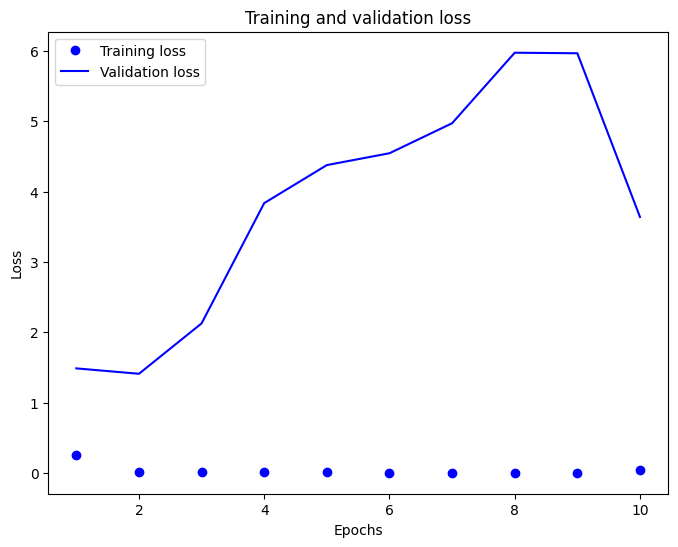

In [20]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

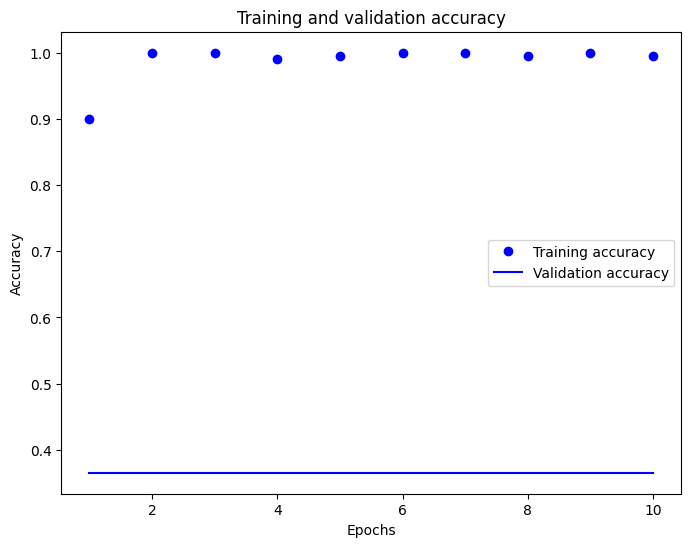

In [21]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 3.639082, final accuracy: 0.365385


In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


1/1 [==============================] - 0s 281ms/step
[[1. 0.]]


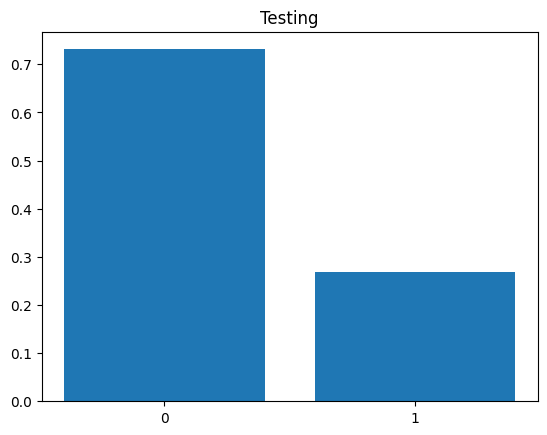

In [24]:
ytopred='/content/dataset/wooddataset/0_tree_18.wav'
file_path = ytopred
sound_info, frame_rate = get_wav_info(file_path)
pylab.specgram(sound_info, Fs=frame_rate)
pylab.savefig(f'{file_path}.png')
fp = f'{file_path}.png'
pylab.close()
img = image.load_img(fp,target_size=(256, 256))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction)
x_labels = ['0', '1']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Testing')
plt.show()